# 1. Import packages

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
VERSION = "v0.1"
# VERSION = "v0.2"

# 2. Load data

In [28]:
train_df = pd.read_csv(f"./DATA/training/btc_data/{VERSION}/train.csv")
val_df = pd.read_csv(f"./DATA/training/btc_data/{VERSION}/val.csv")

features = ['Open', 'High', 'Low', 'Volume']
target = 'Price'

# 3. Preprocess data

## 3.1 Clean data

In [29]:
def clean_data(df: pd.DataFrame):
    df = df.drop(columns=['Change %'])
    df.rename(columns={'Vol.': 'Volume'}, inplace=True)

    df.sort_values('Date', inplace=True)
    df['Volume'] = (
        df['Volume']
        .str.replace('K', 'e3')
        .str.replace('M', 'e6')
        .str.replace('B', 'e9')
        .astype(float)
    )
    columns_to_clean = ['Price', 'Open', 'High', 'Low']
    for col in columns_to_clean:
        df[col] = df[col].str.replace(',', '').astype(float)

    df = df.drop(columns=['Date'])
    return df

In [30]:
train_df = clean_data(train_df)
val_df = clean_data(val_df)

## 3.2 Scale data

In [31]:
features_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [32]:
train_df[features] = features_scaler.fit_transform(train_df[features])
train_df[target] = target_scaler.fit_transform(train_df[[target]])

val_df[features] = features_scaler.transform(val_df[features])
val_df[target] = target_scaler.transform(val_df[[target]])

## 3.3 Create training data

In [33]:
def create_sequences(data: pd.DataFrame, 
                     lookback: int=7
                     )-> tuple:
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data[target][i])
    return np.array(X), np.array(y)

In [34]:
LOOKBACK = 14

X_train, y_train = create_sequences(train_df, LOOKBACK)
X_val, y_val = create_sequences(val_df, LOOKBACK)

## 3.4 Create data loader

In [35]:
class BTCData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
BATCH_SIZE = 16

train_data = BTCData(X_train, y_train)
val_data = BTCData(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

# 4. Modeling

In [37]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.rnn(x)
        x = self.fc1(out[:, -1, :])
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [38]:
input_size = len(features) + 1
hidden_size = 128
num_layers = 2

model = RNN_Model(input_size=input_size,
                  hidden_size=hidden_size, 
                  output_size=1, 
                  num_layers=num_layers)

# 5. Training

In [39]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [40]:
def evaluate(model, loader):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X)
            loss = criterion(y_pred.view(-1), y)
            running_loss += loss.item()
    return running_loss / len(loader)

In [41]:
hist = {
    'train_loss': [],
    'val_loss': []
}

EPOCHS = 30

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.view(-1), y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)

    hist['train_loss'].append(epoch_loss)
    hist['val_loss'].append(val_loss)
    print(f"Epoch {epoch + 1}, train loss: {epoch_loss:.6f}, val loss: {val_loss:.6f}")

Epoch 1, train loss: 0.088656, val loss: 0.065808
Epoch 2, train loss: 0.062953, val loss: 0.037450
Epoch 3, train loss: 0.053649, val loss: 0.024830
Epoch 4, train loss: 0.049315, val loss: 0.018858
Epoch 5, train loss: 0.046529, val loss: 0.015559
Epoch 6, train loss: 0.044212, val loss: 0.013579
Epoch 7, train loss: 0.042070, val loss: 0.012301
Epoch 8, train loss: 0.039918, val loss: 0.011472
Epoch 9, train loss: 0.037766, val loss: 0.010339
Epoch 10, train loss: 0.035612, val loss: 0.009508
Epoch 11, train loss: 0.033397, val loss: 0.009111
Epoch 12, train loss: 0.031181, val loss: 0.008388
Epoch 13, train loss: 0.028918, val loss: 0.007439
Epoch 14, train loss: 0.026616, val loss: 0.006856
Epoch 15, train loss: 0.024264, val loss: 0.006150
Epoch 16, train loss: 0.021928, val loss: 0.005427
Epoch 17, train loss: 0.019665, val loss: 0.004900
Epoch 18, train loss: 0.017473, val loss: 0.004260
Epoch 19, train loss: 0.015350, val loss: 0.003553
Epoch 20, train loss: 0.013317, val loss

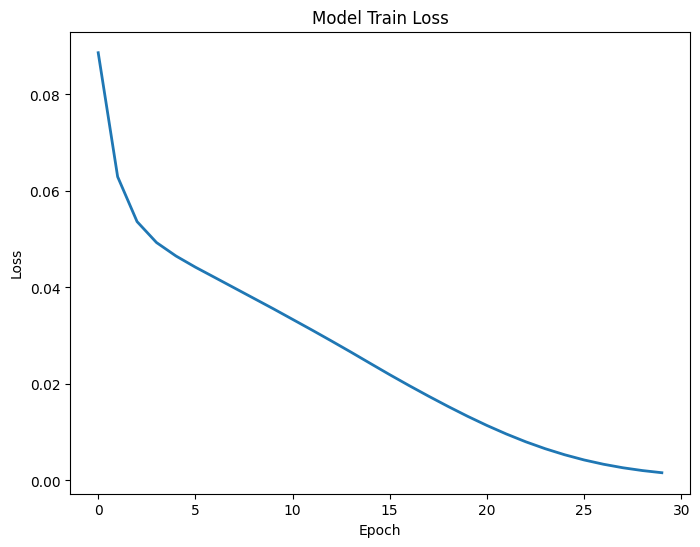

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(hist['train_loss'], label='Train', linewidth=2)
plt.title('Model Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

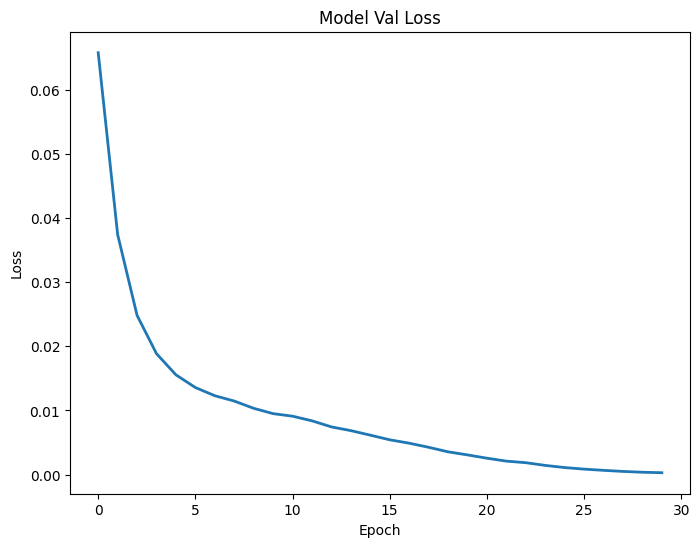

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(hist['val_loss'], label='Train', linewidth=2)
plt.title('Model Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# 6. Testing

In [44]:
test_df = pd.read_csv(f"./DATA/training/btc_data/{VERSION}/test.csv")
test_df = clean_data(test_df)

test_df[features] = features_scaler.transform(test_df[features])
test_df[target] = target_scaler.transform(test_df[[target]])

X_test, y_test = create_sequences(test_df, LOOKBACK)
test_data = BTCData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

test_loss = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.6f}")

Test loss: 0.000890


# 7. Prediction

In [45]:
def predict_futures(model, input_data: pd.DataFrame, features_scaler, target_scaler, next_days=1):
    input_data.loc[:, features] = features_scaler.transform(input_data[features])
    input_data.loc[:, target] = target_scaler.transform(input_data[[target]])
    X_input = torch.tensor(input_data.values, dtype=torch.float32).unsqueeze(0)

    model.eval()
    predictions = []
    for _ in range(next_days):
        with torch.no_grad():
            y_pred = model(X_input)
        y_prediction = y_pred.item()
        predictions.append(y_prediction)
        
        last_row = input_data.iloc[-1].values.tolist()
        next_input = [y_prediction] + last_row[:-1]
        next_input = torch.tensor([next_input], dtype=torch.float32).unsqueeze(1)
        X_input = torch.cat([X_input[:, 1:, :], next_input], dim=1)
    
    unscaled_predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return unscaled_predictions


In [46]:
test_df = pd.read_csv(f"./DATA/training/btc_data/{VERSION}/test.csv")
test_df = clean_data(test_df)

start_date = 15
look_date = 30
next_days = 3

predict_df = test_df[start_date:start_date+look_date]

In [47]:
futures = predict_futures(model, predict_df, features_scaler, target_scaler, next_days=next_days)
futures

array([[28371.47830507],
       [29009.24960818],
       [29137.57520088]])

In [48]:
gt_values = test_df[target].values[start_date+look_date: start_date+look_date+next_days]
gt_values

array([29195.3, 28726.3, 26635.7])

In [49]:
raise Exception("STOP")

Exception: STOP

# 8. Test on new data

In [52]:
test_df = pd.read_csv("./DATA/training/btc_data/v0.2/test.csv")
test_df = clean_data(test_df)

test_df[features] = features_scaler.transform(test_df[features])
test_df[target] = target_scaler.transform(test_df[[target]])

X_test, y_test = create_sequences(test_df, LOOKBACK)
test_data = BTCData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

test_loss = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.6f}") # 0.009371

Test loss: 0.009371
